In [1]:
!git clone https://github.com/Hannibal96/ImageCaptionProject.git

Cloning into 'ImageCaptionProject'...
remote: Enumerating objects: 218, done.
remote: Counting objects: 100% (218/218), done.
remote: Compressing objects: 100% (179/179), done.
remote: Total 218 (delta 124), reused 100 (delta 37), pack-reused 0
Receiving objects: 100% (218/218), 12.00 MiB | 15.16 MiB/s, done.
Resolving deltas: 100% (124/124), done.


In [2]:
%cd ImageCaptionProject/

/content/ImageCaptionProject


In [4]:
!git checkout razi

Branch 'razi' set up to track remote branch 'razi' from 'origin'.
Switched to a new branch 'razi'


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
torch.save??

In [26]:
from data import *
from models import *
import torchvision.transforms as T
from torchtext.vocab import GloVe # for pretrained model
import torch.optim as optim
from torch.utils.data import DataLoader
import pickle
from nltk.translate.bleu_score import sentence_bleu
from tqdm import tqdm

def save_model(model, num_epochs):
    path = "caption_model_E_"+str(num_epochs)+".torch"
    torch.save(model, path)


def evaluate(model, val_data_set):
    blew_score = 0
    total_val_loss = 0

    with torch.no_grad():
        for idx, (image, captions, all_caps) in tqdm(enumerate(iter(val_data_set))):
            image, captions = image.to(device), captions.to(device)

            features = model.encoder(image[0:1].to(device))
            caps, alphas = model.decoder.generate_caption(features, vocab=vocab)
            hyp_caption = ' '.join(caps)
            curr_blew_score = sentence_bleu(references=all_caps[0], hypothesis=hyp_caption.split())
            blew_score += curr_blew_score

            outputs, attentions = model(image, captions)
            outputs = outputs.to(device)
            targets = captions[:, 1:]
            targets = targets.to(device)
            val_loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
            total_val_loss += val_loss.item()

    perplexity = total_val_loss / len(val_data_set)
    perplexity = np.exp(perplexity)
    return blew_score / len(val_data_set), total_val_loss/len(val_data_set), perplexity



In [12]:
!ls $images_path | wc -l

8118


In [27]:


images_path = '/content/drive/MyDrive/ImageCaption/Images'
captions_file_path = "captions.txt"
karpathy_json_path = 'Karpathy_data.json'

# define the transforms to be applied which needed for the pretrained CNN
transforms = T.Compose([
    T.Resize(226),
    T.RandomCrop(224),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

#build vocab
vocab = build_vocab(captions_file_path=captions_file_path)

#build datasets
train, val, test = karpathy_split(captions_file_path, karpathy_json_path)
train_dataset = FlickrDataset(root_dir=images_path,vocab= vocab, captions_df=train,transform=transforms, is_train=True)
val_dataset = FlickrDataset(root_dir=images_path,vocab= vocab, captions_df=val,transform=transforms,is_train=False)
test_dataset = FlickrDataset(root_dir=images_path,vocab= vocab, captions_df=test,transform=transforms,is_train=False)
print("Finished building the Datasets.")

# Hyperparams
weights_matrix = None
# load pretrained embeddings (to train embeddings from scrach just set the embed_size)
#g = GloVe(name ='6B', dim=100)
embed_size = 300#g.dim
#weights_matrix = load_embedding_weights(vocab, g)

vocab_size = len(vocab)
attention_dim = 256
encoder_dim = 2048
decoder_dim = 512
learning_rate = 3e-4
BATCH_SIZE = 32

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# init model
model = EncoderDecoder(
    embed_size=embed_size,
    vocab_size=vocab_size,
    attention_dim=attention_dim,
    encoder_dim=encoder_dim,
    decoder_dim=decoder_dim,
    embedding_weights = weights_matrix
).to(device)

pad_idx = vocab.stoi["<PAD>"]
train_data = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, num_workers=0,
                        shuffle=True, collate_fn=CapsCollate(pad_idx=pad_idx, batch_first=True))
val_data = DataLoader(dataset=val_dataset, batch_size=1, num_workers=0,
                      shuffle=True, collate_fn=CapsCollate(pad_idx=pad_idx, batch_first=True,is_train=False))

criterion = nn.CrossEntropyLoss(ignore_index=vocab.stoi["<PAD>"]).to(device)


100%|██████████| 40455/40455 [00:01<00:00, 23245.92it/s]


Finished building the Datasets.


In [28]:
def train_one_epoch(model, train_data):
  total_loss = 0
  for idx, (image, captions) in tqdm(enumerate(iter(train_data))):
      image, captions = image.to(device), captions.to(device)

      # Zero the gradients.
      optimizer.zero_grad()

      # Feed forward
      outputs, attentions = model(image, captions)
      outputs = outputs.to(device)

      # Calculate the batch loss.
      targets = captions[:, 1:]
      targets = targets.to(device)
      loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))

      # Backward pass.
      loss.backward()

      # Update the parameters in the optimizer.
      optimizer.step()

      total_loss += loss.item()
    
  return total_loss/len(train_data)

In [29]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=0, verbose=True)

num_epochs = 20
print_every = 1000

In [ ]:
loss_list = []
perplexity_list = []
bleu_list = []
total_loss = 0
best_loss = 1000
for epoch in range(1, num_epochs + 1):
    model.train()
    avg_training_loss = train_one_epoch(model, train_data)
    print('average loss = {}'.format(avg_training_loss))

    model.eval()
    bleu, loss, perp = evaluate(model, val_data)
    print("Epoch: {} loss: {:.3f}, perplexity: {:.3f}, BLEU: {:.3f}".format(epoch, loss, perp, bleu))
    # save only best model based on evaluation loss
    if loss < best_loss:
      best_loss = loss
      save_model(model, 1)#overrides previous saved model

    # reduce LR based on evaluation loss (because BLEU is not an accurate perf estimate)
    scheduler.step(loss)
    perplexity_list.append(perp)
    loss_list.append(loss)
    bleu_list.append(bleu)

    pickle.dump(perplexity_list, open('perplexity_list.p', 'wb'))
    pickle.dump(loss_list, open('loss_list.p', 'wb'))
    pickle.dump(bleu_list, open('blew_list.p', 'wb'))


plt.plot(loss_list)
plt.title('Loss')
plt.show()

plt.plot(perplexity_list)
plt.title('Perplexity')
plt.show()

plt.plot(bleu_list)
plt.title('BLEU')
plt.show()

188it [01:25,  2.20it/s]
0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
3it [00:00, 27.28it/s]

average loss = 4.6330318501655094


6it [00:00, 27.84it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
1000it [00:33, 30.11it/s]


Epoch: 1 loss: 4.042, perplexity: 56.954, BLEU: 0.546


188it [01:27,  2.15it/s]
3it [00:00, 29.65it/s]

average loss = 3.868835926055908


1000it [00:34, 29.06it/s]


Epoch: 2 loss: 3.670, perplexity: 39.270, BLEU: 0.496


188it [01:27,  2.14it/s]
3it [00:00, 25.39it/s]

average loss = 3.5980482938441822


1000it [00:34, 29.00it/s]


Epoch: 3 loss: 3.490, perplexity: 32.797, BLEU: 0.490


188it [01:27,  2.14it/s]
3it [00:00, 29.74it/s]

average loss = 3.4082426669749806


1000it [00:33, 29.68it/s]


Epoch: 4 loss: 3.335, perplexity: 28.066, BLEU: 0.495


188it [01:27,  2.16it/s]
3it [00:00, 28.53it/s]

average loss = 3.270242616217187


1000it [00:35, 28.46it/s]


Epoch: 5 loss: 3.226, perplexity: 25.185, BLEU: 0.463


188it [01:27,  2.15it/s]
4it [00:00, 30.35it/s]

average loss = 3.170698655412552


1000it [00:34, 28.92it/s]


Epoch: 6 loss: 3.168, perplexity: 23.770, BLEU: 0.474


188it [01:27,  2.14it/s]
3it [00:00, 26.98it/s]

average loss = 3.0905729976106198


1000it [00:34, 28.91it/s]


Epoch: 7 loss: 3.056, perplexity: 21.249, BLEU: 0.472


188it [01:27,  2.14it/s]
3it [00:00, 27.49it/s]

average loss = 3.0304162185242833


1000it [00:34, 28.60it/s]


Epoch: 8 loss: 3.013, perplexity: 20.358, BLEU: 0.460


188it [01:27,  2.14it/s]
3it [00:00, 23.84it/s]

average loss = 2.9552789482664554


1000it [00:35, 28.12it/s]


Epoch: 9 loss: 2.974, perplexity: 19.567, BLEU: 0.447


188it [01:26,  2.17it/s]
3it [00:00, 27.88it/s]

average loss = 2.9029413753367486


1000it [00:33, 29.49it/s]


Epoch: 10 loss: 2.945, perplexity: 19.019, BLEU: 0.458


42it [00:19,  2.04it/s]

In [19]:
# Evaluate on test data:
model.eval()
test_data = DataLoader(dataset=test_dataset, batch_size=1, num_workers=0,
                      shuffle=True, collate_fn=CapsCollate(pad_idx=pad_idx, batch_first=True,is_train=False))
bleu, loss, perp = evaluate(model, test_data)

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
2it [00:00,  2.09it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
4it [00:01,  2.12it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
1000it [06:59,  2.39it/s]


In [20]:
bleu

0.47214361911252106

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


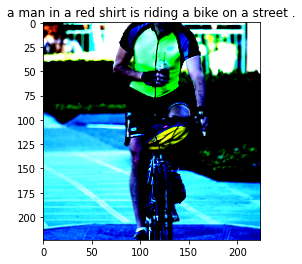

true captions
a biker enjoys a coffee .
A man in a bright green shirt and sunglasses is riding a bicycle through the streets whilst drinking a latte .
A man in a bright green shirt riding a bicycle in a paved courtyard , carying a drink .
A man rides on his bike with one hand and holds a drink with the other .
A man riding a bike wearing a green shirt with a drink in his hand .


In [22]:
with torch.no_grad():
  dataiter = iter(test_data)
  img, _, true_captions = next(dataiter)
  #caps_true = test_dataset.get_last_captions()
  features = model.encoder(img[0:1].to(device))
  caps, alphas = model.decoder.generate_caption(features, vocab=vocab)
  hyp_caption = ' '.join(caps[:-1])
  show_image(img[0], title=hyp_caption)
  print('true captions')
  for i in range(5):
    print(' '.join(true_captions[0][i]))

In [ ]:
test_dataset.captions[0:5]

0    A blond woman in a blue shirt appears to wait ...
1      A blond woman is on the street hailing a taxi .
2    A woman is signaling is to traffic , as seen f...
3    A woman with blonde hair wearing a blue tube t...
4    The woman in the blue dress is holding out her...
Name: caption, dtype: object

[['A',
  'closeup',
  'of',
  'a',
  'white',
  'dog',
  'that',
  'is',
  'laying',
  'its',
  'head',
  'on',
  'its',
  'paws',
  '.'],
 ['a', 'large', 'white', 'dog', 'lying', 'on', 'the', 'floor', '.'],
 ['A', 'white', 'dog', 'has', 'its', 'head', 'on', 'the', 'ground', '.'],
 ['A',
  'white',
  'dog',
  'is',
  'resting',
  'its',
  'head',
  'on',
  'a',
  'tiled',
  'floor',
  'with',
  'its',
  'eyes',
  'open',
  '.'],
 ['A',
  'white',
  'dog',
  'rests',
  'its',
  'head',
  'on',
  'the',
  'patio',
  'bricks',
  '.']]

In [ ]:
captions1 = test_dataset.captions[np.where(test_dataset.imgs == test_dataset.imgs[18])[0]]

In [ ]:
idxs = np.random.randint(size=10,low=0, high=4999)


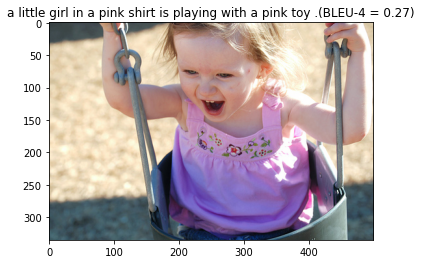

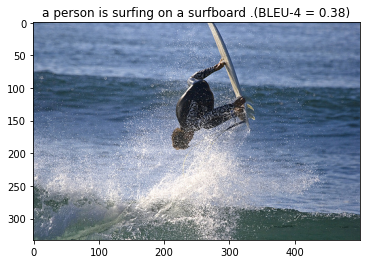

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


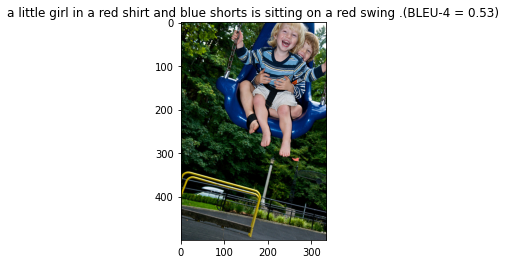

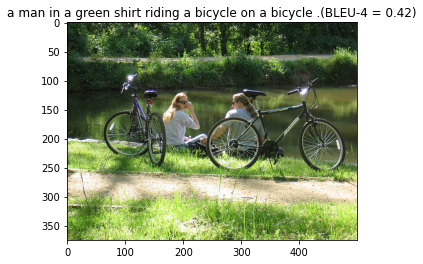

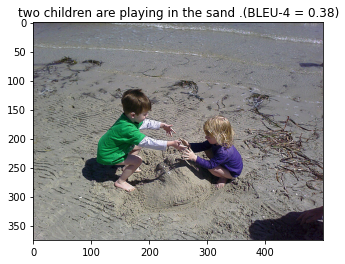

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


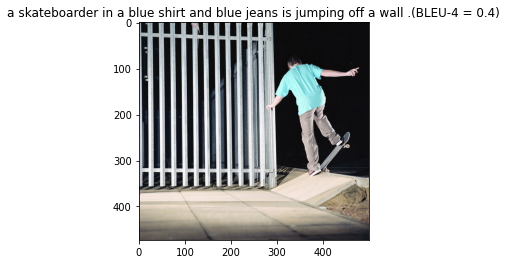

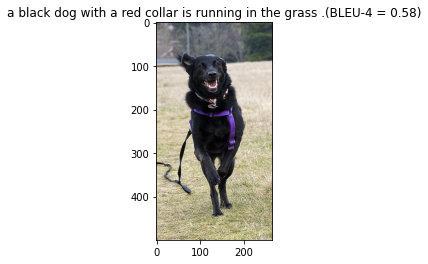

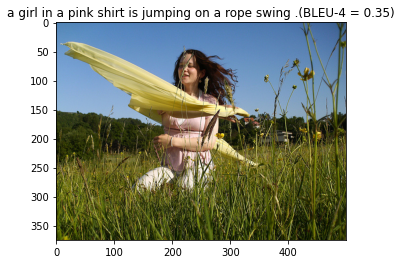

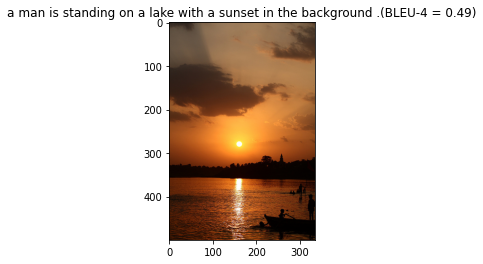

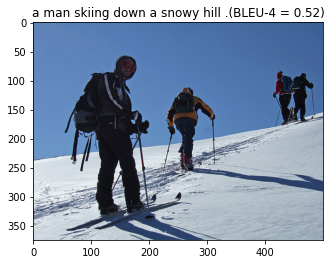

In [ ]:
for idx in idxs:
  #open image & show
  im = Image.open(images_path +'/'+ test_dataset.imgs[idx])
  plt.imshow(im)
  # transform image & generate caption
  img = transforms(im).unsqueeze(0)
  features = model.encoder(img.to(device))
  caps, alphas = model.decoder.generate_caption(features, vocab=vocab)
  hyp_caption = ' '.join(caps[:-1]) #to string
  # get all true 5 captions for our image:
  captions1 = test_dataset.captions[np.where(test_dataset.imgs == test_dataset.imgs[idx])[0]]
  # from strings to list of words
  all_captions = captions1 = [c.split(' ') for c in captions1]
  curr_blew_score = sentence_bleu(references=all_captions, hypothesis=hyp_caption.split())
  plt.title(hyp_caption + '(BLEU-4 = {})'.format(np.round(curr_blew_score,2)))
  plt.show()

In [ ]:
img = transforms(im).unsqueeze(0)

In [ ]:
features = model.encoder(img.to(device))

In [ ]:
caps, alphas = model.decoder.generate_caption(features, vocab=vocab)

In [ ]:
caps

['a',
 'girl',
 'in',
 'a',
 'blue',
 'shirt',
 'is',
 'playing',
 'with',
 'a',
 'blue',
 'toy',
 '.',
 '<EOS>']

In [ ]:
sentence_bleu??